## Data Load

In [14]:
import numpy as np
import pandas as pd
import regex
import re
from PIL import Image
import torch
from torchvision.transforms import v2
from tqdm import tqdm
import os

from collections import Counter
import sys

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# config에서 data 폴더 경로 가져오기
data_dir = "/data/ephemeral/home/data"  # 예: "config/data"

# users.csv 경로 만들기
user_data_path = os.path.join(data_dir, "users.csv")
user_df = pd.read_csv(user_data_path)

book_data_path = os.path.join(data_dir, "books.csv")
book_df = pd.read_csv(book_data_path)

train_rating_data_path = os.path.join(data_dir, "train_ratings.csv")
train_rating_df = pd.read_csv(train_rating_data_path)

## 연령대별 장르(책 주제) 선호도 분석

#### user_df 에 age_winsor 피쳐 추가

In [6]:
# Winsorizing
lower_bound = user_df['age'].quantile(0.05)
upper_bound = user_df['age'].quantile(0.95)

user_df['age_winsor'] = user_df['age'].clip(lower=lower_bound, upper=upper_bound)
bins = [17, 26, 36, 46, 56, 61]  # Winsorized 범위 기준
labels = ['17-25', '26-35', '36-45', '46-55', '56-61']

user_df['age_group'] = pd.cut(user_df['age_winsor'], bins=bins, labels=labels, right=True)

#### book_df 에 category_cluster 피쳐 추가

In [7]:


# -------------------------------
# 2. 카테고리 전처리
# -------------------------------
def preprocess_category(df, col='category', min_len=3):
    """
    - 결측치 처리
    - 소문자화 및 공백 제거
    - 글자수 min_len 미만은 'other'로 치환
    """
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].str.strip().str.lower()
    df.loc[df[col].str.len() < min_len, col] = 'other'
    return df

# -------------------------------
# 3. 텍스트 augmentation
# -------------------------------
def augment_category_text(df, col='category'):
    """
    BERT 임베딩 안정화를 위해 단일 단어 카테고리를 문장 형태로 변환
    """
    df['category_text'] = df[col].apply(lambda x: f"Category: {x}")
    return df

# -------------------------------
# 4. Sentence-BERT 임베딩
# -------------------------------
def embed_categories(df, text_col='category_text', model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    categories = df[text_col].tolist()
    embeddings = model.encode(categories, batch_size=64, show_progress_bar=True)
    return np.array(embeddings)

# -------------------------------
# 5. KMeans 클러스터링
# -------------------------------
def cluster_categories(embeddings, n_clusters=200, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels

# -------------------------------
# 6. 적용 예시
# -------------------------------
# book_df 예시
# book_df = pd.read_csv('books.csv')

# 1) 전처리
book_df = preprocess_category(book_df, col='category', min_len=3)

# 2) 텍스트 augmentation
book_df = augment_category_text(book_df, col='category')

# 3) 임베딩
category_embeddings = embed_categories(book_df, text_col='category_text', model_name='all-MiniLM-L6-v2')

# 4) KMeans 클러스터링
n_clusters = 200  # 필요시 조절
book_df['category_cluster'] = cluster_categories(category_embeddings, n_clusters=n_clusters)

# -------------------------------
# 7. 결과 확인
# -------------------------------
print(book_df[['category', 'category_cluster']].head(10))


Batches:   0%|          | 0/2338 [00:00<?, ?it/s]

        category  category_cluster
0  ['actresses']               102
1  ['1940-1949']               143
2    ['medical']                39
3    ['fiction']                 0
4    ['history']                 4
5        unknown                 1
6    ['fiction']                 0
7    ['fiction']                 0
8        unknown                 1
9        unknown                 1


#### full_df 생성 : .columns = ['user_id', 'age_group','isbn', 'category_cluster']

In [8]:
# user_df + train_rating_df merge
full_df = train_rating_df.merge(user_df[['user_id', 'age_group']], on='user_id', how='left')

# full_df + book_df merge
full_df = full_df.merge(book_df[['isbn', 'category_cluster']], on='isbn', how='left')

# 확인
full_df.head()


,user_id,isbn,rating,age_group,category_cluster
0,8,0002005018,4,NaN,102
1,67544,0002005018,7,26-35,102
2,123629,0002005018,8,NaN,102
3,200273,0002005018,8,NaN,102
4,210926,0002005018,9,NaN,102


In [9]:
age_genre_rating = full_df.groupby(['age_group', 'category_cluster'])['rating'].mean().unstack()
print(age_genre_rating)


category_cluster       0         1         2         3         4         5    \
age_group                                                                      
17-25             7.126110  7.151796  7.598395  7.067416  7.152610  7.360595   
26-35             7.024469  7.097435  7.795835  6.883929  7.466418  7.395152   
36-45             7.093555  7.156069  7.885409  7.109589  7.732673  7.382101   
46-55             7.431071  7.430505  7.511727  7.023256  7.576503  7.571922   
56-61             6.997461  7.229552  7.678363  6.673913  7.448113  7.213198   

category_cluster       6         7         8         9    ...       190  \
age_group                                                 ...             
17-25             7.274194  7.786517  6.945946  7.592405  ...  7.285714   
26-35             7.146535  7.605634  6.753425  7.583141  ...  6.500000   
36-45             7.219298  7.858491  7.039370  7.537118  ...  6.451613   
46-55             7.804805  8.296296  7.147239  7.259053  ...  7

/tmp/ipykernel_803615/2610984382.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_genre_rating = full_df.groupby(['age_group', 'category_cluster'])['rating'].mean().unstack()


#### 유효 데이터 수

In [19]:
# 전체 데이터 수
total_count = full_df.shape[0]

# 유효 데이터 수 (age_group 결측 아님 & category_cluster != 1)
valid_df = full_df[(full_df['age_group'].notna()) & (full_df['category_cluster'] != 1)]
valid_count = valid_df.shape[0]

# 비율 계산
valid_ratio = valid_count / total_count

print(f"유효한 데이터 수: {valid_count}")
print(f"전체 데이터 대비 비율: {valid_ratio:.2%}")


유효한 데이터 수: 123953
전체 데이터 대비 비율: 40.40%


In [20]:
# 유효 데이터만 추출
valid_df = full_df[(full_df['age_group'].notna()) & (full_df['category_cluster'] != 1)]

# 연령대별 갯수
age_counts = valid_df.groupby('age_group').size()

# 전체 대비 비율
age_ratio = age_counts / full_df.shape[0]

# 갯수와 비율 합치기
age_summary = pd.DataFrame({
    'count': age_counts,
    'proportion': age_ratio
})

# 보기 좋게 정렬
age_summary = age_summary.sort_index()

print(age_summary)


           count  proportion
age_group                   
17-25      22316    0.072739
26-35      43792    0.142740
36-45      28354    0.092420
46-55      21033    0.068557
56-61       8458    0.027569


/tmp/ipykernel_803615/1025286950.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = valid_df.groupby('age_group').size()


### 데이터 불균형 (cluster 별 데이터 갯수 불균형 & 나잇대 별 데이터 불균형) 처리 아직임.

In [10]:
# 각 연령대-장르별 rating 총합 / 전체 rating 총합
age_genre_count = full_df.groupby(['age_group', 'category_cluster']).size().unstack(fill_value=0)

# 비율로 변환
age_genre_ratio = age_genre_count.div(age_genre_count.sum(axis=1), axis=0)
print(age_genre_ratio)


category_cluster       0         1         2         3         4         5    \
age_group                                                                      
17-25             0.323287  0.406899  0.056317  0.002365  0.006618  0.021448   
26-35             0.346776  0.403558  0.033355  0.003051  0.007300  0.022473   
36-45             0.354126  0.398604  0.029800  0.003097  0.008569  0.027255   
46-55             0.389641  0.387311  0.027324  0.003758  0.010662  0.025314   
56-61             0.391635  0.399375  0.012143  0.003267  0.015055  0.027979   

category_cluster       6         7         8         9    ...       190  \
age_group                                                 ...             
17-25             0.006591  0.002365  0.003933  0.010498  ...  0.000372   
26-35             0.006878  0.001934  0.004971  0.011795  ...  0.000790   
36-45             0.009672  0.002248  0.005387  0.009714  ...  0.000658   
46-55             0.009700  0.002360  0.004748  0.010458  ...  0

/tmp/ipykernel_803615/4291294400.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_genre_count = full_df.groupby(['age_group', 'category_cluster']).size().unstack(fill_value=0)


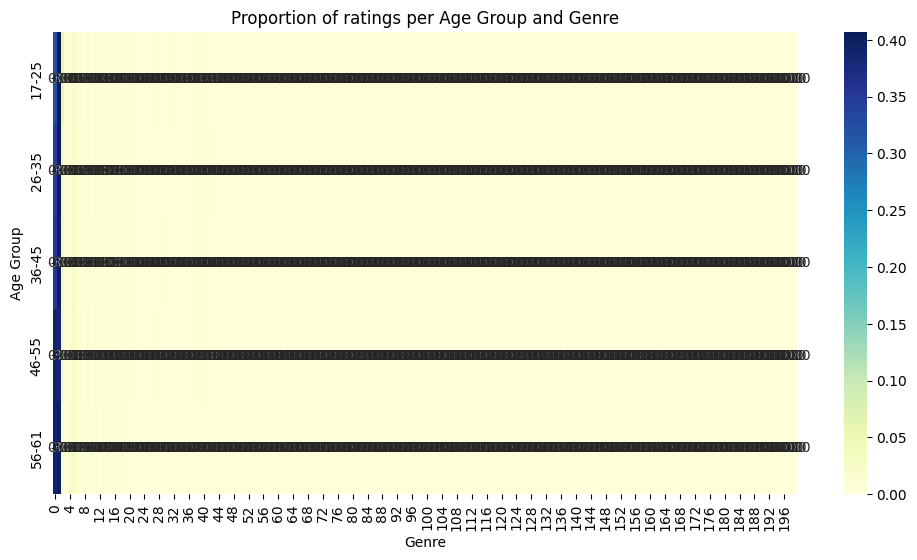

In [15]:


plt.figure(figsize=(12,6))
sns.heatmap(age_genre_ratio, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Proportion of ratings per Age Group and Genre")
plt.xlabel("Genre")
plt.ylabel("Age Group")
plt.show()


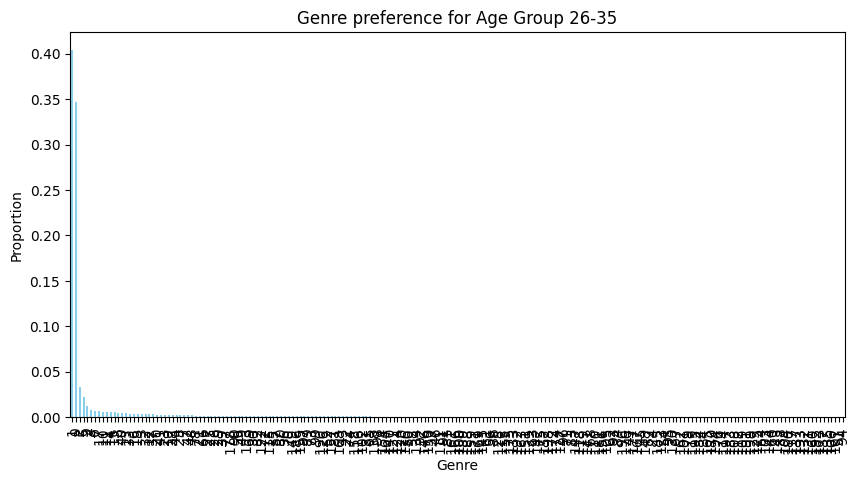

In [16]:
age_group_to_plot = '26-35'
age_genre_ratio.loc[age_group_to_plot].sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title(f'Genre preference for Age Group {age_group_to_plot}')
plt.ylabel('Proportion')
plt.xlabel('Genre')
plt.show()


### .

In [21]:
# -------------------------------
# 8. 클러스터별 데이터 개수 및 비율 확인
# -------------------------------

# cluster별 개수
cluster_counts = book_df['category_cluster'].value_counts().sort_index()

# 전체 데이터 수
total_count = len(book_df)

# 비율 계산
cluster_ratio = cluster_counts / total_count * 100

# 데이터프레임으로 보기 좋게 합치기
cluster_summary = pd.DataFrame({
    'count': cluster_counts,
    'ratio (%)': cluster_ratio
})

# 소수점 2자리로 포맷
cluster_summary['ratio (%)'] = cluster_summary['ratio (%)'].round(2)

print(cluster_summary)


                  count  ratio (%)
category_cluster                  
0                 33024      22.08
1                 68851      46.03
2                  5884       3.93
3                   701       0.47
4                  1951       1.30
...                 ...        ...
195                  36       0.02
196                  46       0.03
197                  16       0.01
198                  44       0.03
199                  53       0.04

[200 rows x 2 columns]


In [26]:
# 유효 데이터만 사용 (age_group notna & category_cluster != 1)
valid_df = full_df[(full_df['age_group'].notna()) & (full_df['category_cluster'] != 1)]

# 연령대별 장르 Count
age_genre_count = valid_df.groupby(['age_group', 'category_cluster']).size().unstack(fill_value=0)

# 연령대별 장르 비율
age_genre_ratio = age_genre_count.div(age_genre_count.sum(axis=1), axis=0)

print(age_genre_ratio.head())

top_n = 5
min_rating_count = 50
age_top_genres = {}

for age in valid_df['age_group'].unique():
    temp = valid_df[valid_df['age_group'] == age]
    
    # cluster별 rating 수 확인
    cluster_counts = temp.groupby('category_cluster')['rating'].count()
    clusters_to_use = cluster_counts[cluster_counts >= min_rating_count].index
    
    # 평균 rating 계산
    mean_ratings = temp[temp['category_cluster'].isin(clusters_to_use)].groupby('category_cluster')['rating'].mean()
    
    # top N 장르
    top_genres = mean_ratings.sort_values(ascending=False).head(top_n)
    age_top_genres[age] = top_genres


# 예시 출력
for age, top_gen in age_top_genres.items():
    print(f"Age Group {age} top {top_n} genres:")
    print(top_gen)
    print()


category_cluster       0         2         3         4         5         6    \
age_group                                                                      
17-25             0.545080  0.094954  0.003988  0.011158  0.036162  0.011113   
26-35             0.581408  0.055923  0.005115  0.012240  0.037678  0.011532   
36-45             0.588841  0.049552  0.005149  0.014248  0.045320  0.016082   
46-55             0.635953  0.044597  0.006133  0.017401  0.041316  0.015832   
56-61             0.652045  0.020218  0.005439  0.025065  0.046583  0.016671   

category_cluster       7         8         9         10   ...       190  \
age_group                                                 ...             
17-25             0.003988  0.006632  0.017700  0.005825  ...  0.000627   
26-35             0.003243  0.008335  0.019775  0.010299  ...  0.001324   
36-45             0.003738  0.008958  0.016153  0.009910  ...  0.001093   
46-55             0.003851  0.007750  0.017068  0.006181  ...  0

/tmp/ipykernel_803615/4155349587.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_genre_count = valid_df.groupby(['age_group', 'category_cluster']).size().unstack(fill_value=0)


In [27]:
from collections import Counter
import re

# 텍스트 전처리 함수 (소문자화, 특수문자 제거)
def preprocess_category(text):
    text = str(text).lower()  # 소문자화
    text = re.sub(r'[^a-z0-9\s]', '', text)  # 특수문자 제거
    words = text.split()
    return words

# cluster별 category 단어 추출
cluster_top_words = {}

for cluster in book_df['category_cluster'].unique():
    # cluster에 속한 책들의 category 모으기
    categories = book_df.loc[book_df['category_cluster'] == cluster, 'category'].dropna()
    
    # 단어 리스트로 변환
    words = []
    for cat in categories:
        words.extend(preprocess_category(cat))
    
    if words:
        # 가장 자주 등장하는 단어 5개 추출
        top_words = [word for word, _ in Counter(words).most_common(5)]
        cluster_top_words[cluster] = top_words
    else:
        cluster_top_words[cluster] = []

# 예시 출력
for cluster, words in list(cluster_top_words.items())[:10]:  # 상위 10개 cluster만
    print(f"Cluster {cluster}: {words}")


Cluster 102: ['motion', 'picture', 'and', 'actresses', 'actors']
Cluster 143: ['war', 'world', '19391945', 'battle', 'of']
Cluster 39: ['medical', 'medicine', 'alternative', 'popular', 'physicians']
Cluster 0: ['fiction', 'autobiographical', 'humorous', 'authors', 'general']
Cluster 4: ['history', 'modern', 'natural', 'chronology', 'historical']
Cluster 1: ['unknown']
Cluster 48: ['nature', 'ecology', 'human', 'biodiversity', 'naturalists']
Cluster 9: ['humor', 'comedians', 'black', 'jokes', 'comedy']
Cluster 15: ['cooking', 'cookery', 'american', 'food', 'vegetarian']
Cluster 23: ['reference', 'bibliography', 'bibliographical', 'citations']


In [28]:
for age, top_gen in age_top_genres.items():
    print(f"Age Group {age} Top {top_n} Genres:")
    for cluster, rating in top_gen.items():
        words = cluster_top_words.get(cluster, [])
        print(f"Cluster {cluster} ({', '.join(words)}): {rating:.2f}")
    print()


Age Group 26-35 Top 5 Genres:
Cluster 26 (crafts, hobbies, arts, and): 7.97
Cluster 126 (imaginary, place, dune, discworld, wars): 7.96
Cluster 48 (nature, ecology, human, biodiversity, naturalists): 7.91
Cluster 89 (fantasy, magic, games, entertaining, legends): 7.89
Cluster 69 (character, fictitious, baggins, frodo, covenant): 7.88

Age Group 56-61 Top 5 Genres:
Cluster 7 (art, arts, painting, modern, and): 9.09
Cluster 17 (body, mind, spirit, human, and): 8.36
Cluster 6 (religion, catholics, and, religions, hinduism): 7.91
Cluster 2 (fiction, juvenile, young, adult, best): 7.68
Cluster 11 (social, science, sociology, sciences, elite): 7.55

Age Group 46-55 Top 5 Genres:
Cluster 26 (crafts, hobbies, arts, and): 8.56
Cluster 7 (art, arts, painting, modern, and): 8.30
Cluster 23 (reference, bibliography, bibliographical, citations): 7.89
Cluster 48 (nature, ecology, human, biodiversity, naturalists): 7.83
Cluster 28 (pets, dogs, dog, dalmatian, breeds): 7.82

Age Group 17-25 Top 5 Genr

In [29]:
top_n = 5
min_rating_count = 50  # 최소 평가수 필터
age_low_genres = {}

for age in valid_df['age_group'].unique():
    temp = valid_df[valid_df['age_group'] == age]
    
    # cluster별 rating 수 확인 후 최소 평가수 이상 필터
    cluster_counts = temp.groupby('category_cluster')['rating'].count()
    clusters_to_use = cluster_counts[cluster_counts >= min_rating_count].index
    
    # 평균 rating 계산
    mean_ratings = temp[temp['category_cluster'].isin(clusters_to_use)].groupby('category_cluster')['rating'].mean()
    
    # 낮은 Top N 장르
    low_genres = mean_ratings.sort_values(ascending=True).head(top_n)
    age_low_genres[age] = low_genres

# 출력 예시
for age, low_gen in age_low_genres.items():
    print(f"Age Group {age} Lowest {top_n} Genres (mean rating, min {min_rating_count} ratings):")
    print(low_gen)
    print()


Age Group 26-35 Lowest 5 Genres (mean rating, min 50 ratings):
category_cluster
168    6.407407
190    6.500000
12     6.519048
102    6.549020
149    6.666667
Name: rating, dtype: float64

Age Group 56-61 Lowest 5 Genres (mean rating, min 50 ratings):
category_cluster
0     6.997461
8     7.072464
5     7.213198
9     7.254098
13    7.280488
Name: rating, dtype: float64

Age Group 46-55 Lowest 5 Genres (mean rating, min 50 ratings):
category_cluster
16    6.922222
12    6.965517
3     7.023256
10    7.092308
13    7.114094
Name: rating, dtype: float64

Age Group 17-25 Lowest 5 Genres (mean rating, min 50 ratings):
category_cluster
12    6.670455
38    6.807692
27    6.861538
13    6.868613
33    6.910959
Name: rating, dtype: float64

Age Group 36-45 Lowest 5 Genres (mean rating, min 50 ratings):
category_cluster
157    6.365385
12     6.705426
26     6.849315
8      7.039370
0      7.093555
Name: rating, dtype: float64



In [30]:
# 예시 출력
for cluster, words in list(cluster_Lowest_words.items())[:10]:  # 상위 10개 cluster만
    print(f"Cluster {cluster}: {words}")


NameError: name 'cluster_Lowest_words' is not defined